In [2]:
import matplotlib.pyplot as plt
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
import rasterstats
import sys
import os
module_path = os.path.abspath(os.path.join('..', 'libs'))
if module_path not in sys.path:
    sys.path.append(module_path)
from s3utils import *

In [3]:
S3 = S3Helper('roof-index')
s3_path = 'missoula/geospatial/'
height = S3.read_tif_from_s3_as_rio(s3_path + 'downtown_height.tif')
bldgs = S3.read_shp_from_s3_as_gpd(s3_path + 'downtown_bldgs.zip').to_crs(6514)
height_arr = height.read(1)
affine = height.transform

In [4]:
zstats = rasterstats.zonal_stats(bldgs, height_arr, affine=affine,
    nodata=height.nodata, geojson_out=True, stats="median")

## Add bldg height to GeoDataFrame

In [5]:
bh = []
for b in zstats:
    bh_temp = (b['properties']['fid'], b['properties']['median'])
    bh.append(bh_temp)

bh_df = gpd.GeoDataFrame(bh, columns=['fid', 'bldg_height'])
full_data = pd.merge(bldgs, bh_df)
full_data['bldg_height'] = full_data['bldg_height']*3.28084
full_data       

,fid,AVG_HEIGHT,MIN_LAG,area_sq_ft,geometry,bldg_height
0,1.0,27.32460,3202.73,44334.900,MULTIPOLYGON Z (((257091.482 300124.221 27.325...,28.529631
1,2.0,11.80030,3204.72,5449.480,"POLYGON Z ((257170.740 300266.436 11.800, 2571...",12.199623
2,3.0,11.44360,3205.74,3658.490,"POLYGON Z ((257170.172 300185.933 11.444, 2571...",12.334789
3,4.0,30.45860,3205.99,13970.200,MULTIPOLYGON Z (((257408.449 300123.800 30.459...,43.546823
4,5.0,10.99220,3204.42,6748.850,"POLYGON Z ((257175.485 300291.266 10.992, 2571...",11.196688
...,...,...,...,...,...,...
958,959.0,10.41030,3217.27,566.998,"POLYGON Z ((258263.976 301156.751 10.410, 2582...",11.782509
959,960.0,17.13810,3214.29,2976.740,"POLYGON Z ((258224.819 301179.597 17.138, 2582...",21.138430
960,961.0,16.08160,3217.24,1456.870,"POLYGON Z ((258300.759 301228.699 16.082, 2582...",20.784193
961,962.0,9.34612,3216.50,272.249,"POLYGON Z ((258217.425 301179.456 9.346, 25822...",11.143923


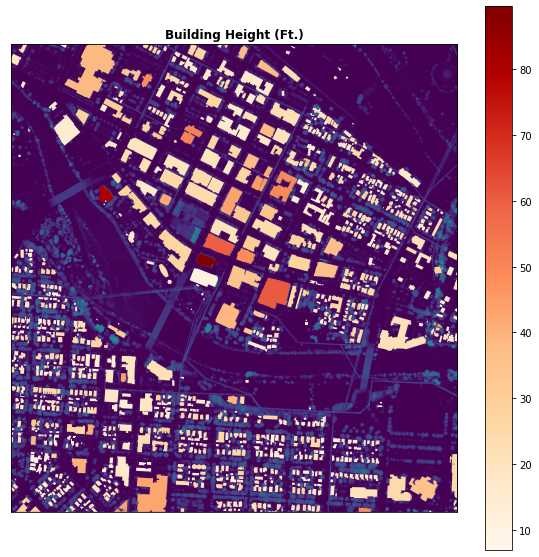

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
show(height, ax=ax, title='Building Height (Ft.)')
full_data.plot(column='bldg_height', legend=True, ax=ax, cmap='OrRd')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.show()